<a href="https://colab.research.google.com/github/hvr2026/Clustering-Algorithms/blob/main/Clustering%20With%20Images/Clustering_with_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install all required packages
!pip install git+https://github.com/facebookresearch/ImageBind.git
!pip install scikit-learn matplotlib seaborn umap-learn plotly torchvision


  Cloning https://github.com/facebookresearch/ImageBind.git to /tmp/pip-req-build-k_hcd7pv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/ImageBind.git /tmp/pip-req-build-k_hcd7pv
  Resolved https://github.com/facebookresearch/ImageBind.git to commit 3fcf5c9039de97f6ff5528ee4a9dce903c5979b3
  Preparing metadata (setup.py) ... done
  Using cached pytorchvideo-0.1.5-py3-none-any.whl
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached timm-0.6.7-py3-none-any.whl.metadata (33 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached eva_decord-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (449 bytes)
  Using cached iopath-0.1.10-py3-none-any.whl
  Using cached types_regex-2024.11.6.20241108-py3-none-any.whl.metadata (1.8 kB)
  Using cached mayavi-4.8.2.tar.gz (7.1 MB)
  Installing build dependencies ... done
  Getting requi

In [11]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances, jaccard_score
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import CLIPProcessor, CLIPModel
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from urllib.request import urlretrieve


In [15]:
# Step 1: Download sample images from valid online URLs
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/640px-Golde33443.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/36/Hopetoun_falls.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Example.jpg/800px-Example.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/5/51/Google.png"
]

# Step 1: Fix directory structure for ImageFolder
os.makedirs("images/dummy_class", exist_ok=True)  # Create a dummy class folder

# Move images into the dummy class folder
for i, url in enumerate(image_urls):
    try:
        urlretrieve(url, f"images/dummy_class/image_{i}.jpg")
    except Exception as e:
        print(f"Error downloading {url}: {e}")



In [19]:
# Step 2: Load images into a dataset
print("\nStep 2: Loading images into dataset...")
transform = Compose([Resize((224, 224)), ToTensor()])
image_folder = ImageFolder(root="images", transform=transform)
image_loader = torch.utils.data.DataLoader(image_folder, batch_size=32, shuffle=False)
print(f"Total images loaded: {len(image_folder)}")


Step 2: Loading images into dataset...
Total images loaded: 5


In [20]:
# Step 3: Initialize the CLIP model
print("\nStep 3: Initializing CLIP model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(f"Model initialized on device: {device}")


Step 3: Initializing CLIP model...
Model initialized on device: cuda


In [21]:
# Step 4: Generate embeddings for images
print("\nStep 4: Generating embeddings...")
embeddings = []
image_paths = []
clip_model.eval()
with torch.no_grad():
    for images, _ in image_loader:
        images = images.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        image_embeddings = clip_model.get_image_features(**inputs)
        embeddings.append(image_embeddings.cpu().numpy())
        image_paths.extend(image_folder.samples[i][0] for i in range(len(images)))
        print(f"Processed batch of {len(images)} images.")
embeddings = np.vstack(embeddings)
print(f"Total embeddings generated: {embeddings.shape}")


Step 4: Generating embeddings...
Processed batch of 5 images.
Total embeddings generated: (5, 512)


In [22]:
# Step 5: Perform PCA to reduce embedding dimensions
print("\nStep 5: Performing PCA...")
n_components = min(embeddings.shape[0], embeddings.shape[1]) - 1
pca = PCA(n_components=n_components)
embeddings_pca = pca.fit_transform(embeddings)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"PCA reduced dimensions to {n_components} components.")


Step 5: Performing PCA...
PCA reduced dimensions to 4 components.


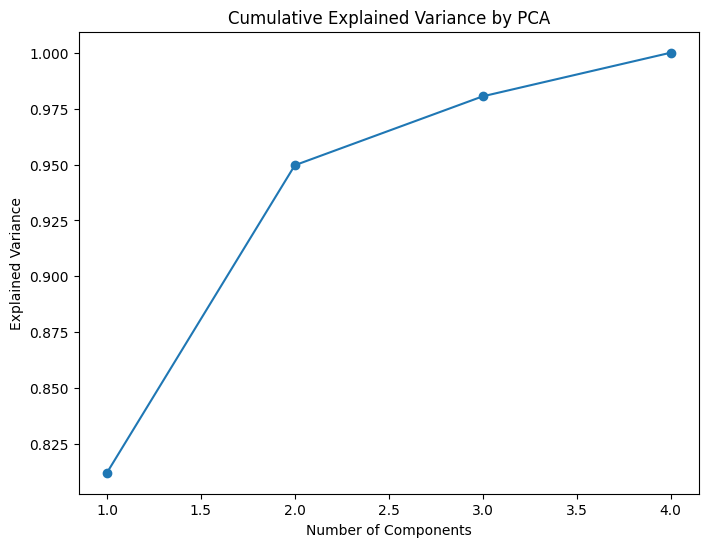

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.show()

In [24]:
# Step 6: Cluster the embeddings using KMeans
print("\nStep 6: Clustering with KMeans...")
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_pca)
print(f"KMeans clustering completed with {n_clusters} clusters.")


Step 6: Clustering with KMeans...
KMeans clustering completed with 3 clusters.



Step 7: Visualizing clusters using UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


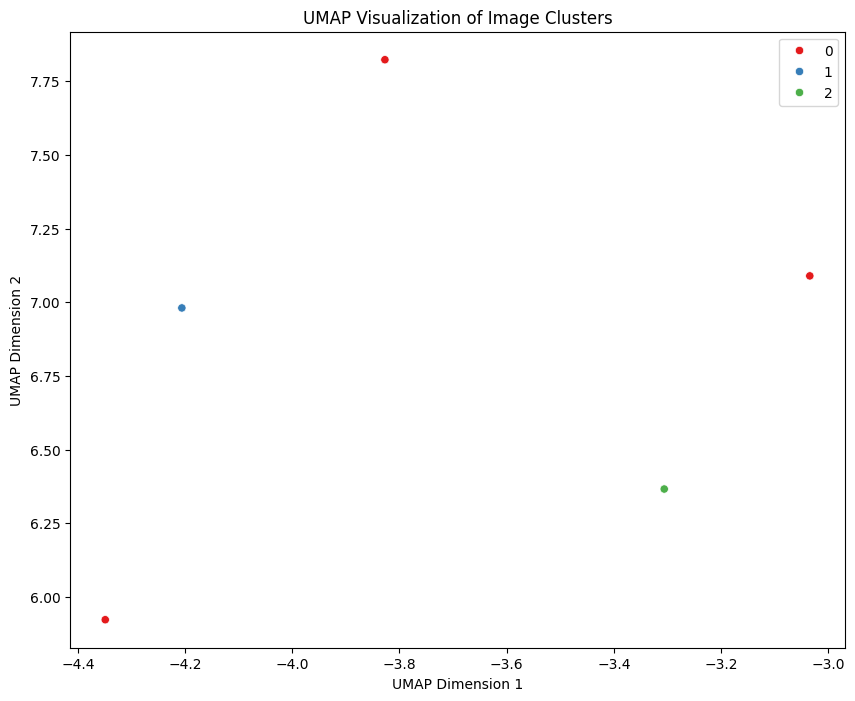

In [25]:
# Step 7: Visualize image clusters using UMAP
print("\nStep 7: Visualizing clusters using UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=clusters, palette="Set1", legend="full")
plt.title("UMAP Visualization of Image Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()


Step 8: Displaying sample images by cluster...
Cluster 0:


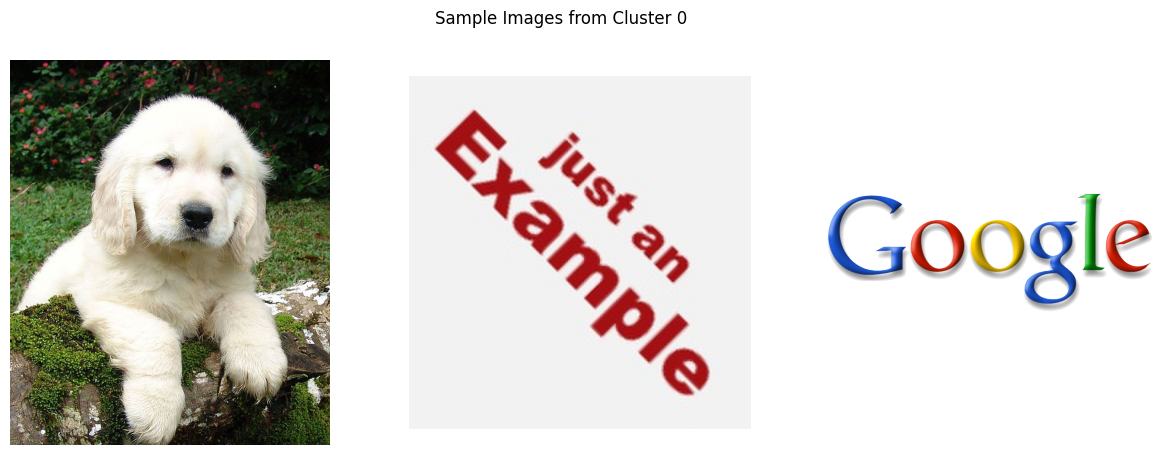

Cluster 1:


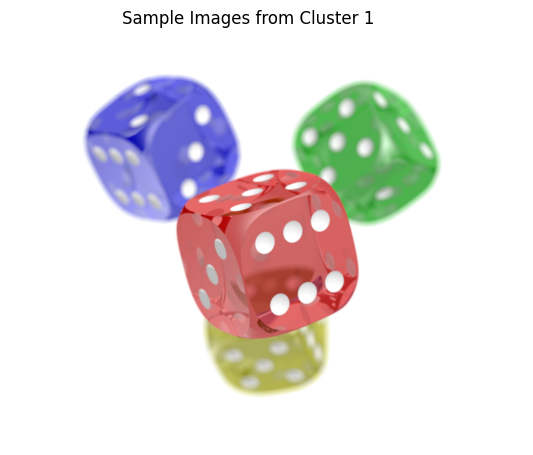

Cluster 2:


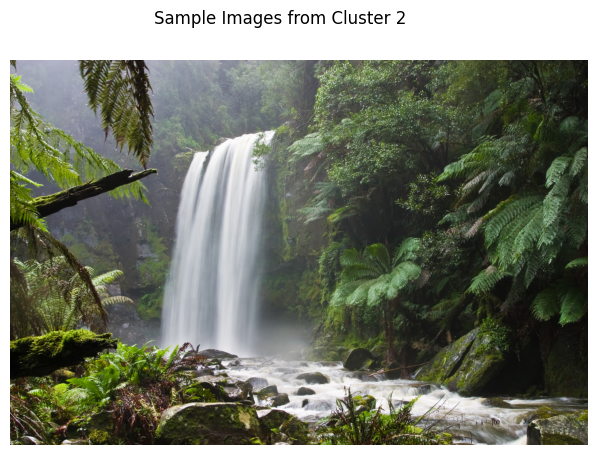

In [27]:
# Step 8: Display sample images by cluster
print("\nStep 8: Displaying sample images by cluster...")

def show_images_from_cluster(cluster_id, num_images=5):
    cluster_images = [image_paths[i] for i in range(len(clusters)) if clusters[i] == cluster_id]
    cluster_images = cluster_images[:num_images]

    # Handle single image case by ensuring axs is always iterable
    fig, axs = plt.subplots(1, max(len(cluster_images), 1), figsize=(15, 5))
    if len(cluster_images) == 1:
        axs = [axs]  # Make axs a list for consistent iteration

    for ax, img_path in zip(axs, cluster_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(f"Sample Images from Cluster {cluster_id}")
    plt.show()

# Display sample images for each cluster
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    show_images_from_cluster(cluster_id)



Step 9: Analyzing cluster sizes...
   Cluster  Size
0        0     3
1        1     1
2        2     1


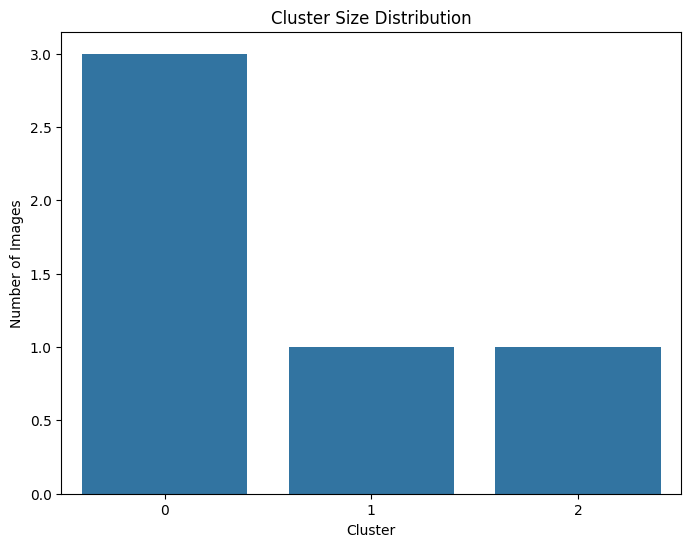

In [28]:
# Step 9: Analyze cluster sizes
print("\nStep 9: Analyzing cluster sizes...")
cluster_sizes = pd.DataFrame({"Cluster": clusters}).value_counts().reset_index()
cluster_sizes.columns = ["Cluster", "Size"]
print(cluster_sizes)

plt.figure(figsize=(8, 6))
sns.barplot(x="Cluster", y="Size", data=cluster_sizes)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.show()


Step 10: Calculating pairwise cluster distances...


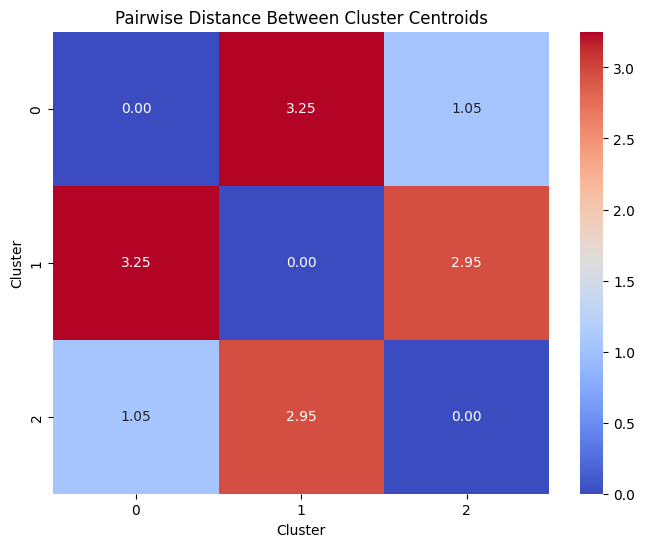

In [29]:
# Step 10: Display pairwise cluster distances
print("\nStep 10: Calculating pairwise cluster distances...")
distance_matrix = pairwise_distances(kmeans.cluster_centers_)
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Pairwise Distance Between Cluster Centroids")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()


Step 11: Distribution of embedding values...


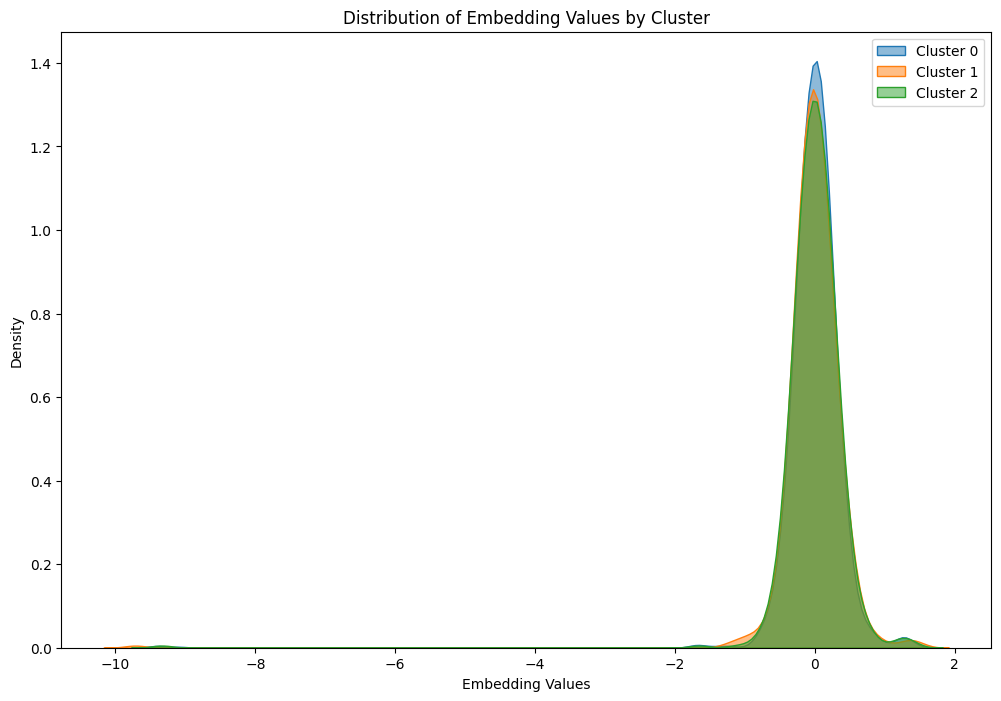

In [50]:
# Step 11: Distribution of embedding values for each cluster
print("\nStep 11: Distribution of embedding values...")
plt.figure(figsize=(12, 8))
for cluster_id in range(n_clusters):
    sns.kdeplot(embeddings[clusters == cluster_id].ravel(), label=f"Cluster {cluster_id}", fill=True, alpha=0.5)
plt.title("Distribution of Embedding Values by Cluster")
plt.xlabel("Embedding Values")
plt.ylabel("Density")
plt.legend()
plt.show()

In [49]:
# Step 12: Compactness analysis (intra-cluster distances)
print("\nStep 12: Compactness analysis...")
def compute_cluster_compactness(cluster_id):
    cluster_points = embeddings[clusters == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    return np.mean(distances)


Step 12: Compactness analysis...


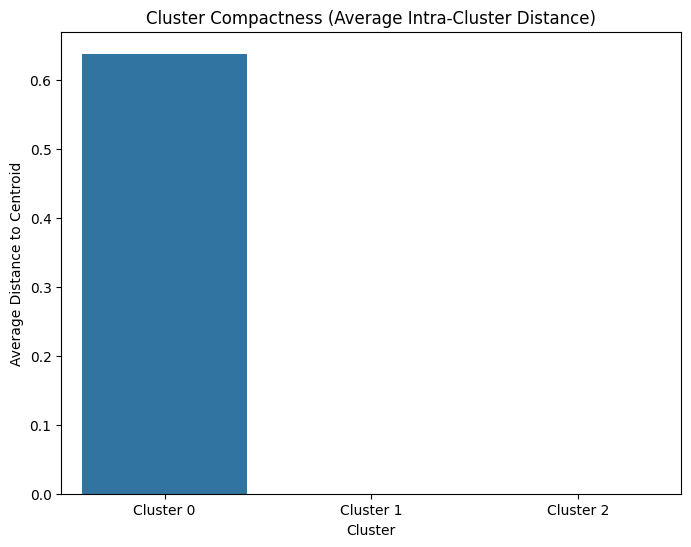

In [36]:
compactness_scores = [compute_cluster_compactness(i) for i in range(n_clusters)]
plt.figure(figsize=(8, 6))
sns.barplot(x=[f"Cluster {i}" for i in range(n_clusters)], y=compactness_scores)
plt.title("Cluster Compactness (Average Intra-Cluster Distance)")
plt.xlabel("Cluster")
plt.ylabel("Average Distance to Centroid")
plt.show()


Step 13: PCA component importance...


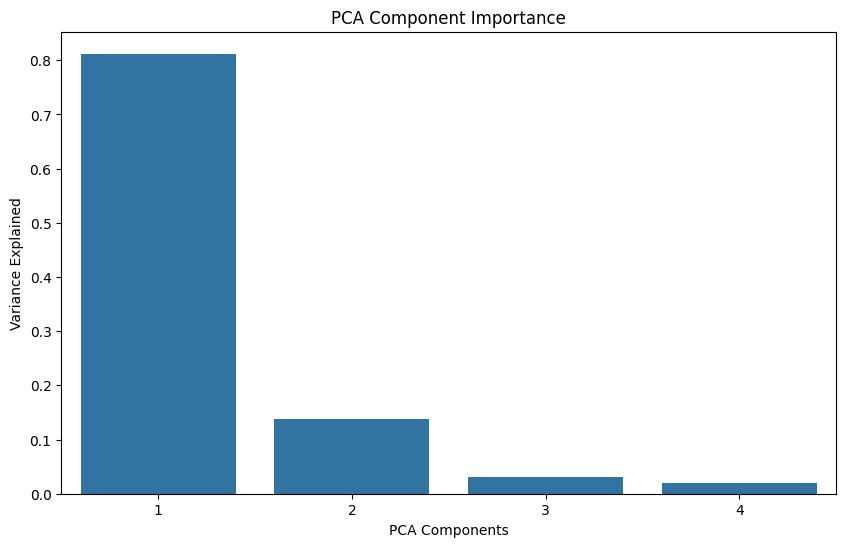

In [51]:
# Step 13: PCA component importance visualization
print("\nStep 13: PCA component importance...")
pca_importance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
sns.barplot(x=range(1, len(pca_importance) + 1), y=pca_importance)
plt.title("PCA Component Importance")
plt.xlabel("PCA Components")
plt.ylabel("Variance Explained")
plt.show()


Step 14: Analyzing cluster stability...


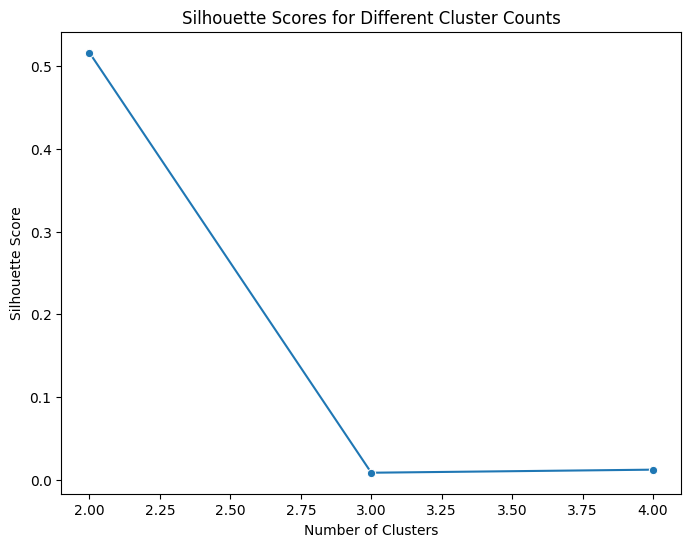

In [52]:
# Step 14: Analyze cluster stability
print("\nStep 14: Analyzing cluster stability...")
max_clusters = min(10, embeddings_pca.shape[0] - 1)  # Ensure we have fewer clusters than samples
silhouette_scores = []
cluster_range = range(2, max_clusters + 1)  # Start from 2 clusters

for n in cluster_range:
    kmeans_temp = KMeans(n_clusters=n, random_state=42)
    temp_clusters = kmeans_temp.fit_predict(embeddings_pca)
    sil_score = silhouette_score(embeddings_pca, temp_clusters)
    silhouette_scores.append(sil_score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
sns.lineplot(x=cluster_range, y=silhouette_scores, marker="o")
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()



Step 15: Comparing clustering methods...


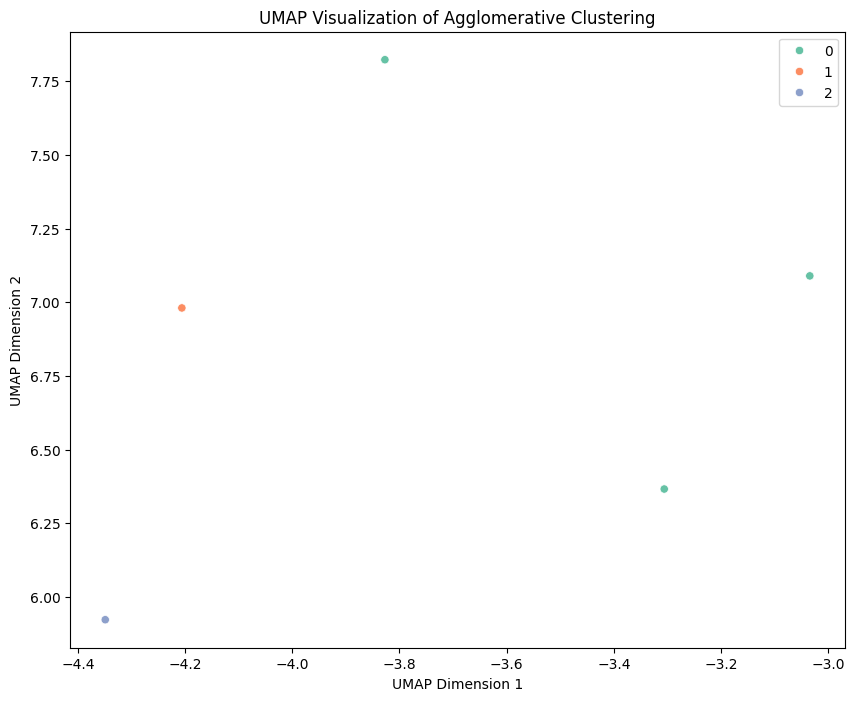

In [53]:
# Step 15: Compare clustering methods
print("\nStep 15: Comparing clustering methods...")
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
agglo_clusters = agglo.fit_predict(embeddings_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=agglo_clusters, palette="Set2", legend="full")
plt.title("UMAP Visualization of Agglomerative Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()


Step 16: Outlier detection...


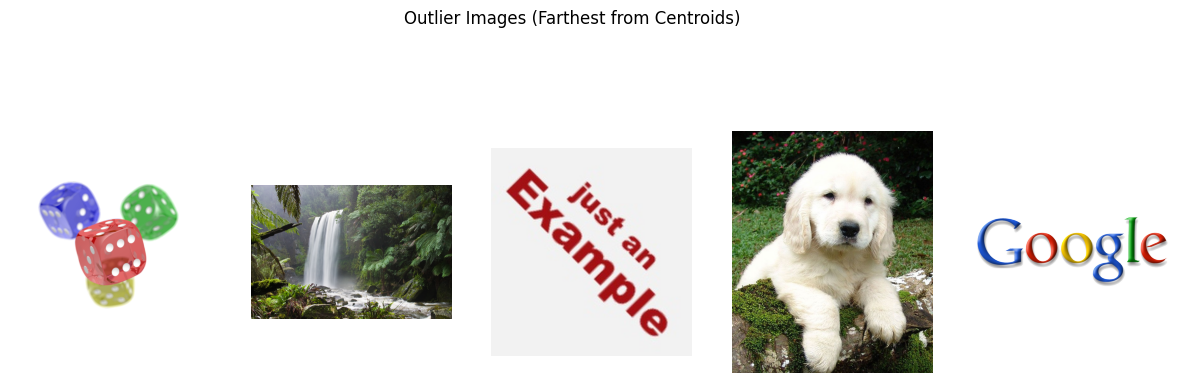

In [54]:
# Step 16: Outlier detection (most distant from centroids)
print("\nStep 16: Outlier detection...")
distances_from_centroid = np.array([
    np.linalg.norm(embedding - kmeans.cluster_centers_[cluster], axis=0)
    for embedding, cluster in zip(embeddings_pca, clusters)
])

outlier_indices = distances_from_centroid.argsort()[-5:]  # Get 5 most distant points
outlier_paths = [image_paths[i] for i in outlier_indices]

# Visualize outliers
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, img_path in zip(axs, outlier_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("Outlier Images (Farthest from Centroids)")
plt.show()


Step 17: 3D t-SNE visualization...


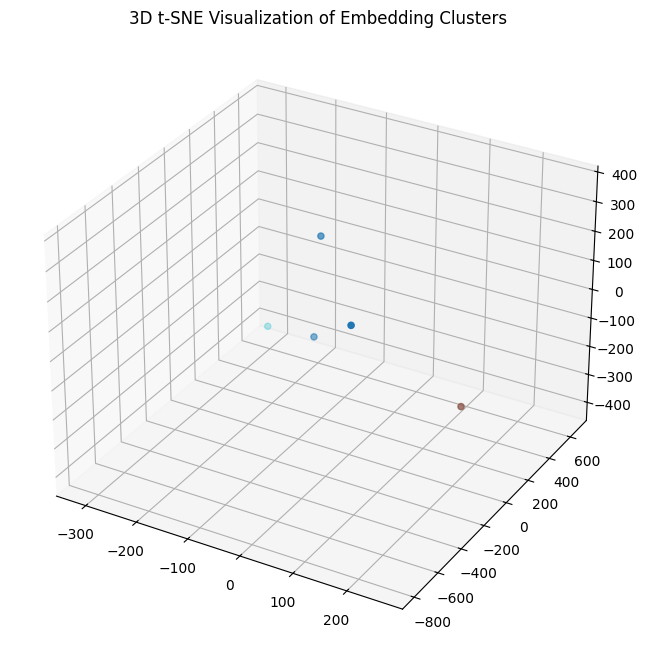

t-SNE completed with perplexity=1 for 5 samples.


In [55]:
# Step 17: 3D t-SNE visualization
print("\nStep 17: 3D t-SNE visualization...")
n_samples = embeddings_pca.shape[0]
perplexity = min(30, n_samples // 3)  # Adjust perplexity based on number of samples

tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
tsne_embeddings = tsne.fit_transform(embeddings_pca)

# Plot 3D t-SNE results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], c=clusters, cmap="tab10")
plt.title("3D t-SNE Visualization of Embedding Clusters")
plt.show()

print(f"t-SNE completed with perplexity={perplexity} for {n_samples} samples.")



Step 18: Jaccard overlap between clusters...


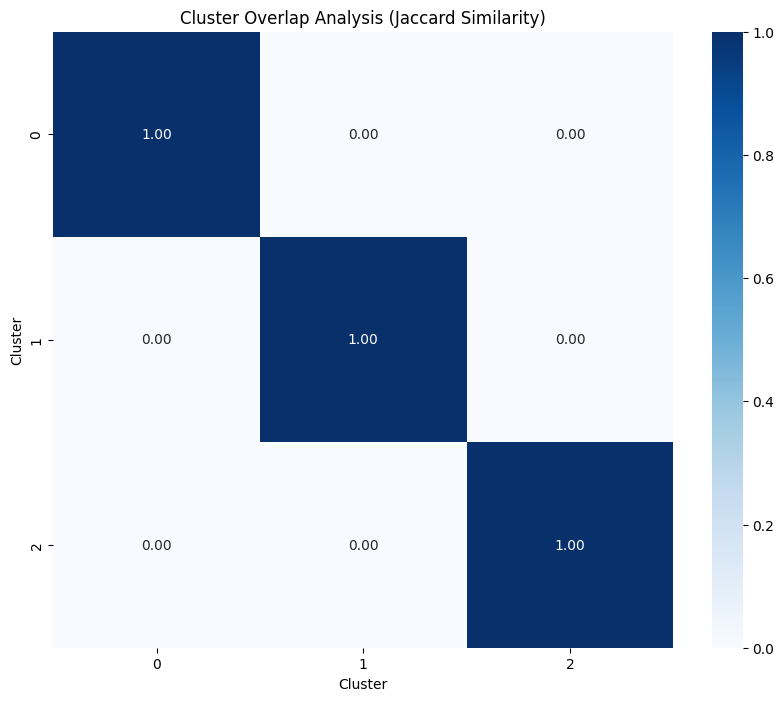

In [56]:
# Step 18: Jaccard overlap between clusters
print("\nStep 18: Jaccard overlap between clusters...")
overlap_matrix = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        overlap_matrix[i, j] = jaccard_score(clusters == i, clusters == j, average="binary")

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Cluster Overlap Analysis (Jaccard Similarity)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

In [57]:
# Step 19: Interactive visualization with Plotly
print("\nStep 19: Interactive 3D visualization...")
df_tsne = pd.DataFrame(tsne_embeddings, columns=["Dim1", "Dim2", "Dim3"])
df_tsne["Cluster"] = clusters

fig = px.scatter_3d(df_tsne, x="Dim1", y="Dim2", z="Dim3", color="Cluster", title="3D Interactive t-SNE")
fig.show()

print("\n--- Analysis Completed ---")


Step 19: Interactive 3D visualization...



--- Analysis Completed ---
